# Generating the graph for a single submission

This notebook contains code from the 'Phase1_Network_Graph.ipynb' notebook, but it considers only a single submission and generates the graphs.

# **the code is up to date**

# Structural Competition and Aggressive Behavior
----
This notebook looks at 3 different methods to generate the edges between two given users. The notebook is experimenting wit the three approaches but the code is not correct<br>
1. method 1 : generates a undirected graph. The weight of an undirected edge between userA and userB is (the total number of comments between A and B in the submission)/(the total number of comments on the submission). This is then aggregated across all submissions in the subreddit.<br>
2. method 2a: generates a directed graph. The weight of a directed edge from userA to userB is (the total number of comments from A to B in the submission)/(the total number of comments to B in the submission). This is then aggregated across all submissions in the subreddit.<br>
3. method 2b: generates a directed graph. The weight of a directed edge from userA to userB is (the total number of comments from A to B across all submissions in the subreddit)/(the total number of comments to B in the across all submissions in the subreddit).<br>
----
## *PHASE 1: Network Data*
The steps for the network data are approximately as follows: <br>

**Part 1: Data Exploration And Cleaning**
1.   Read the json data
2.   Data Description
3.   Consider one subreddit subreddit_id=t5_22i0
**Part 2: Creating the Method1 Edges- capturing the interaction between users who all comment on the same submission**
3.   The edge between any two users is the total number of interactions they both made on the post / total number of comments on the post.
4.   Aggregate the directed edges across submissions by taking the average edge weights
**Part 3: Generate The Network for Method1 Edges**
6. Construct the network edgelists from the user interaction/reply data
7. Map this into a NetworkX graph
8. Train the node2vec embedding model
**Part 4: Creating the Method2a Edges- capturing the interaction between users pairs who reply to each other**
9. The directed edge between any two users ui and uj is the total number of times ui replied to uj/the total number of responses to user uj in the submission. This is an directed graph.
10. Aggregate the directed edges across submissions by taking the average edge weights
**Part 5: Generate The Network for Method2a Edges**
11. Construct the network edgelists from the user interaction/reply data
12. Map this into a NetworkX graph
13. Train the node2vec embedding model
**Part 6: Creating the Method2b Edges- capturing the interaction between users pairs who reply to each other**
14. The directed edge between any two users ui and uj is the total number of times ui replied to uj across all submissions/the total number of responses to user uj across all submissions. This is a directed graph.
**Part 7: Generate The Network for Method2b Edges**
15. Construct the network edgelists from the user interaction/reply data
16. Map this into a NetworkX graph
17. Train the node2vec embedding model

---
Reading the data
---


.

In [ ]:
import torch
if torch.cuda.is_available():
    device_name = torch.device("cuda")
else:
    device_name = torch.device('cpu')
print("Using {}.".format(device_name))

Using cpu.


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import pandas as pd
data_submission_t3_5lbzj0 = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/reddit_project/data_submission_t3_5lbzj0.csv')
print(len(data_submission_t3_5lbzj0)) #length of data = 12
print(len(pd.unique(data_submission_t3_5lbzj0['subreddit_id']))) #number of subreddits considered = 1
print(len(pd.unique(data_submission_t3_5lbzj0['id']))) #unique number of comments = , the data is at the comment level = 12
print(len(pd.unique(data_submission_t3_5lbzj0['parent_id']))) #number of parent nodes = 4
print(len(pd.unique(data_submission_t3_5lbzj0['link_id']))) #number of submissions = 1

12
1
12
4
1


In [ ]:
data_submission_t3_5lbzj0

,Unnamed: 0,edited,id,parent_id,distinguished,created_utc,author_flair_text,author_flair_css_class,controversiality,subreddit_id,retrieved_on,link_id,author,score,gilded,stickied,body,subreddit
0,7955,0,dbumtxv,t3_5lbzj0,NaN,1483229087,NaN,NaN,0,t5_22i0,1485679794,t3_5lbzj0,[deleted],1,0,False,[deleted],de
1,153109,0,dbupywv,t1_dbuiogs,NaN,1483234150,Bayern,BAVA,0,t5_22i0,1485681522,t3_5lbzj0,Madjura,5,0,False,&gt;Clown\n\n[Bitte auch richtig aussprechen!]...,de
2,533324,0,dbuy767,t3_5lbzj0,NaN,1483249885,Nämberch,NUERN,0,t5_22i0,1485685479,t3_5lbzj0,bkifft,2,0,False,"Altes Material ist alt: QI Staffel 2 Folge 8 ""...",de
3,616845,0,dbv005l,t3_5lbzj0,NaN,1483254268,NaN,NaN,0,t5_22i0,1485686348,t3_5lbzj0,farEast11,1,0,False,Bumerang,de
4,702648,0,dbv1uyi,t1_dbul82z,NaN,1483259676,NaN,NaN,0,t5_22i0,1485687237,t3_5lbzj0,Seventh_Planet,1,0,False,"Wer die Wahrheit sagt, braucht ein schnelles P...",de
5,758119,0,dbv323c,t3_5lbzj0,NaN,1483263883,NaN,NaN,0,t5_22i0,1485687812,t3_5lbzj0,upsetbob,3,0,False,Wie nennt man ein helles Mammut?\n\n\nHelmut,de
6,758963,0,dbv32r4,t3_5lbzj0,NaN,1483263952,NaN,NaN,0,t5_22i0,1485687822,t3_5lbzj0,upsetbob,4,0,False,Welcher Fisch furzt einen halben Ton tiefer?\n...,de
7,770217,0,dbv3bjm,t3_5lbzj0,NaN,1483264868,Sauerland,TEXT,0,t5_22i0,1485687939,t3_5lbzj0,Alcatruzt,5,0,False,"Kommt ein Pferd in einen Blumenladen: ""Ham se ...",de
8,772264,0,dbv3d52,t3_5lbzj0,NaN,1483265044,Sauerland,TEXT,0,t5_22i0,1485687960,t3_5lbzj0,Alcatruzt,2,0,False,"Kommt ein Luftballon zum Arzt: ""Herr Doktor, i...",de
9,920500,0,dbv6kfu,t1_dbupywv,NaN,1483277448,NaN,NaN,0,t5_22i0,1485689497,t3_5lbzj0,[deleted],1,0,False,[deleted],de


---
Generate Graph for 1 submission using Method 2a
---


.

In [ ]:
data_method2a = pd.DataFrame(columns=['subreddit_id','submission_id','from_user','to_user','edgeweight_method2a'])
print(data_method2a)

Empty DataFrame
Columns: [subreddit_id, submission_id, from_user, to_user, edgeweight_method2a]
Index: []


In [ ]:
def method2a_function(subreddit_id, subreddit_data):
  data_method2a = pd.DataFrame(columns=['subreddit_id','submission_id','from_user','to_user','edgeweight_method2a'])
  #print(data_method2a)

  #obtain the link_id's of all submission in the subreddit
  submissions_list = subreddit_data['link_id'].unique()
  #obtain the names of all user's in the subreddit
  #author_list = subreddit_data['author'].unique()
  #print(author_list[0])
  #print(author_list[1])

  print("Consider subreddit with ID: ",subreddit_id)
  print("total number of submission: ",len(submissions_list))
  counter = 0
  ignore_comments_counter = 0

  #iterate across all submissions
  for i in submissions_list:
    print('\n***********************')
    counter += 1
    curr_link_id = i
    print("consider submission with link_id = "+str(curr_link_id)+ " ("+str(counter)+"/"+str(len(submissions_list))+")")

    #obtain all comments made on this submission from the subreddit
    submission_comments = subreddit_data.loc[subreddit_data['link_id'] == curr_link_id]
    #print(submission_comments.head(3))

    #obtain the names of all user's in the subsmission
    author_list = submission_comments['author'].unique()
    print("total number of authors: ",len(author_list))

    #number of comments on the subreddit
    tot_comments = len(submission_comments)
    print("total number of comments in this submission = ", tot_comments)
    j = 0

    #iterate across the current submission
    for index, row in submission_comments.iterrows():
      j += 1
      #print('comment '+str(j)+" ---------------")

      curr_author = row['author']
      curr_parent_comment_id = row['parent_id'][3:] #noticed that the parent id is nothing but the comment id preceded by 3 characters
      #print(curr_parent_comment_id)

      #identify if a comment is a primary comment
      primary_comment_flag = 0
      if row['parent_id'] == row['link_id']: #it is a primary comment
        #print("primary comment")
        primary_comment_flag = 1

      #rule out any comment that does not have a valid parent in the submission
      #(the parent id of a given comment should be either (i) the link id itslef for a primary comment
      # or
      # the id of another comment in the submission)
      if(len(submission_comments[submission_comments['id'] == curr_parent_comment_id]['author']) == 0): #the parent comment could not be found
        #print(primary_comment_flag)
        #if (primary_comment_flag == 1):
          #print('this comment is a reply to the submission and hence will not have an edge')
        #else:
          #print('this comment was made as a reply to another comment which cannot be found in the data')
        #print('there')
        ignore_comments_counter += 1
        continue

      primary_comment_flag = 0
      #print('Found a valid parent comment in the submission')
      curr_parent = submission_comments[submission_comments['id'] == curr_parent_comment_id]['author'].values[0]
      #print('The parent comment was made by author: '+str(curr_parent))
      curr_comment_id = row['id']

      all_replies_to_parent_df = submission_comments[(submission_comments["parent_id"] == row['parent_id'])]
      if len(all_replies_to_parent_df) == 0:
        #print('reached here 1')
        ignore_comments_counter += 1
        continue
      curr_author_all_replies_to_parent_df = all_replies_to_parent_df[(all_replies_to_parent_df["author"] == curr_author)]
      if len(curr_author_all_replies_to_parent_df) == 0:
        #print('reached here 2')
        ignore_comments_counter += 1
        continue
      else:
        #print("edge weight for this comment: "+str(len(curr_author_all_replies_to_parent_df))+"/"+str(len(all_replies_to_parent_df)))
        #weighted_interaction_between_curr_and_curr_parent = float("{:.2f}".format((len(curr_author_all_replies_to_parent_df)/len(all_replies_to_parent_df))))
        weighted_interaction_between_curr_and_curr_parent = ((len(curr_author_all_replies_to_parent_df)/len(all_replies_to_parent_df)))
        #add the row to the dataframe
        if len(data_method2a[(data_method2a['from_user'] == curr_author)&(data_method2a['to_user'] == curr_parent)&(data_method2a['submission_id'] == curr_link_id)].values) > 0: #there exists a row with the curr_aithor to curr_parent in the same submission already
          #print('here')
          ignore_comments_counter += 1
          continue
        else:
          data_method2a.loc[len(data_method2a.index)] = [subreddit_id, curr_link_id, curr_author, curr_parent, weighted_interaction_between_curr_and_curr_parent]
          #print('length of submission data frame: '+str(len(data_method2a)))

    #data_method2a.append(data_method2a_local,ignore_index=True)
    #print(data_method2a_local)
    #print('appended, new length of data frame: '+str(len(data_method2a)))
  print('total number of comments ignored: ' +str(ignore_comments_counter))
  return data_method2a

data_method2a = method2a_function('t3_5lbzj0',data_submission_t3_5lbzj0)


Consider subreddit with ID:  t3_5lbzj0
total number of submission:  1

***********************
consider submission with link_id = t3_5lbzj0 (1/1)
total number of authors:  9
total number of comments in this submission =  12
total number of comments ignored: 10


In [ ]:
print(len(data_method2a))
print(data_method2a.head(3))

2
  subreddit_id submission_id  from_user  to_user  edgeweight_method2a
0    t3_5lbzj0     t3_5lbzj0  [deleted]  Madjura                  0.5
1    t3_5lbzj0     t3_5lbzj0      keylu  Madjura                  0.5


In [ ]:
data_method2a_final = pd.DataFrame(columns=['from_user','to_user','edgeweight_method2a'])
print(data_method2a_final)

Empty DataFrame
Columns: [from_user, to_user, edgeweight_method2a]
Index: []


In [ ]:
data_method2a_final = data_method2a.groupby(['submission_id','from_user', 'to_user'], as_index=False)['edgeweight_method2a'].mean()

In [ ]:
print(len(data_method2a_final))
print(data_method2a_final.columns)
print(data_method2a_final.head(140))

2
Index(['submission_id', 'from_user', 'to_user', 'edgeweight_method2a'], dtype='object')
  submission_id  from_user  to_user  edgeweight_method2a
0     t3_5lbzj0  [deleted]  Madjura                  0.5
1     t3_5lbzj0      keylu  Madjura                  0.5


In [ ]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
G_method2a = nx.from_pandas_edgelist(data_method2a_final, "from_user", "to_user", edge_attr="edgeweight_method2a", create_using=nx.DiGraph()) #weight for graph not set

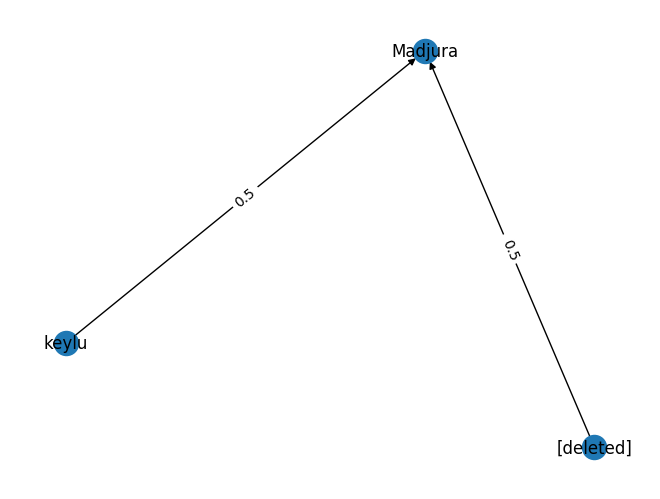

In [ ]:
pos = nx.spring_layout(G_method2a, k=1)  # For better example looking
nx.draw(G_method2a, pos, with_labels=True)
labels = {e: G_method2a.edges[e]['edgeweight_method2a'] for e in G_method2a.edges}
nx.draw_networkx_edge_labels(G_method2a, pos, edge_labels=labels)
plt.show()

In [ ]:
print(G_method2a.number_of_nodes())
print(G_method2a.number_of_edges()) #edges same as number of rows
print(np.mean([d for _, d in G_method2a.degree()])) #average degree of nodes
print(G_method2a.size(weight='edgeweight_method2a'))

3
2
1.3333333333333333
1.0


In [ ]:
pip install node2vec

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 7.2 MB/s eta 0:00:00
  Attempting uninstall: networkx
    Found existing installation: networkx 3.1
    Uninstalling networkx-3.1:
      Successfully uninstalled networkx-3.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.


In [ ]:
from node2vec import Node2Vec as n2v

In [ ]:
WINDOW = 1 # Node2Vec fit window
MIN_COUNT = 1 # Node2Vec min. count
BATCH_WORDS = 4 # Node2Vec batch words

g_emb = n2v(G_method2a,dimensions=128)

mdl2 = g_emb.fit(
    vector_size = 128,
    window=WINDOW,
    min_count=MIN_COUNT,
    batch_words=BATCH_WORDS
)

Computing transition probabilities:   0%|          | 0/3 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:00<00:00, 20836.09it/s]


In [ ]:
comment_id = 'Madjura'
for s in mdl2.wv.most_similar(comment_id, topn = 10):
    print(s)

('[deleted]', 0.06308098882436752)
('keylu', -0.03183373808860779)


---
Generate Graph for 1 submission using Method 2b
---


.

In [ ]:
data_method2b = pd.DataFrame(columns=['subreddit_id','submission_id','from_user','to_user','num', 'denom'])
print(data_method2b)

Empty DataFrame
Columns: [subreddit_id, submission_id, from_user, to_user, num, denom]
Index: []


In [ ]:
def method2b_function(subreddit_id, subreddit_data):
  submissions_list = subreddit_data['link_id'].unique()

  print("Consider subreddit with ID: ",subreddit_id)
  print("total number of submission: ",len(submissions_list))
  counter = 0
  ignore_comments_counter = 0

  #number of comments on the subreddit
  tot_comments = len(subreddit_data)
  print("total number of comments in this submission = ", tot_comments)

  #iterate across the current submission
  for index, row in subreddit_data.iterrows():
      curr_link_id = row['link_id']
      curr_author = row['author']
      curr_parent_comment_id = row['parent_id'][3:] #noticed that the parent id is nothing but the comment id preceded by 3 characters

      if(len(subreddit_data[subreddit_data['id'] == curr_parent_comment_id]['author']) == 0): #the parent comment could not be found
        ignore_comments_counter += 1
        continue

      #print('Found a valid parent comment in the submission')
      curr_parent = subreddit_data[subreddit_data['id'] == curr_parent_comment_id]['author'].values[0]

      all_replies_to_parent_df = subreddit_data[(subreddit_data["parent_id"] == row['parent_id'])]
      if len(all_replies_to_parent_df) == 0:
        ignore_comments_counter += 1
        continue
      curr_author_all_replies_to_parent_df = all_replies_to_parent_df[(all_replies_to_parent_df["author"] == curr_author)]
      if len(curr_author_all_replies_to_parent_df) == 0:
        ignore_comments_counter += 1
        continue
      else:
        if len(data_method2b[(data_method2b['from_user'] == curr_author)&(data_method2b['to_user'] == curr_parent)].values) > 0: #there exists a row with the curr_author to curr_parent in the same submission already
          ignore_comments_counter += 1
          continue
        else:
          data_method2b.loc[len(data_method2b.index)] = [subreddit_id, curr_link_id, curr_author, curr_parent,len(curr_author_all_replies_to_parent_df), len(all_replies_to_parent_df) ]

  print('total number of comments ignored: ' +str(ignore_comments_counter))
  return data_method2b

data_method2b = method2b_function('t3_5lbzj0',data_submission_t3_5lbzj0)


Consider subreddit with ID:  t3_5lbzj0
total number of submission:  1
total number of comments in this submission =  12
total number of comments ignored: 10


In [ ]:
print(len(data_method2b))
print(data_method2b)

2
  subreddit_id submission_id  from_user  to_user  num  denom
0    t3_5lbzj0     t3_5lbzj0  [deleted]  Madjura    1      2
1    t3_5lbzj0     t3_5lbzj0      keylu  Madjura    1      2


In [ ]:
data_method2b_final = pd.DataFrame(columns=['from_user','to_user','num','denom'])
print(data_method2b_final)

Empty DataFrame
Columns: [from_user, to_user, num, denom]
Index: []


In [ ]:
data_method2b_final = data_method2b.groupby(['from_user', 'to_user'], as_index=False).agg({'num':'sum','denom':'sum'})

In [ ]:
print(len(data_method2b_final))
print(data_method2b_final.columns)
print(data_method2b_final.head(140))

2
Index(['from_user', 'to_user', 'num', 'denom'], dtype='object')
   from_user  to_user  num  denom
0  [deleted]  Madjura    1      2
1      keylu  Madjura    1      2


In [ ]:
data_method2b_final['edgeweight_method2b'] = data_method2b_final['num']/data_method2b_final['denom']

In [ ]:
data_method2b_final.head()

,from_user,to_user,num,denom,edgeweight_method2b
0,[deleted],Madjura,1,2,0.5
1,keylu,Madjura,1,2,0.5


In [ ]:
G_method2b = nx.from_pandas_edgelist(data_method2b_final, "from_user", "to_user", edge_attr="edgeweight_method2b", create_using=nx.DiGraph()) #weight for graph not set

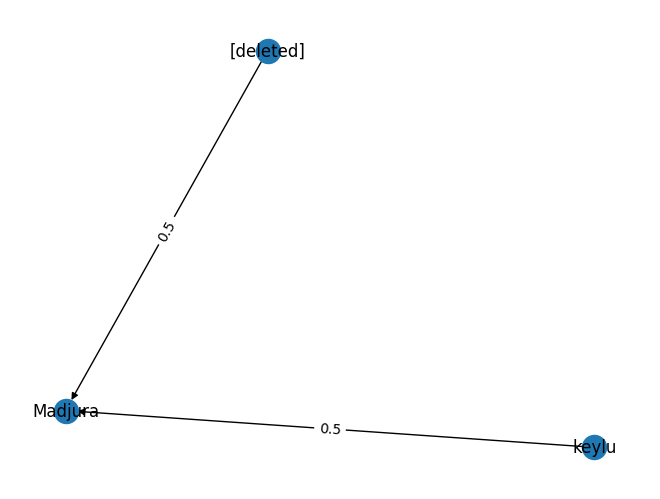

In [ ]:
pos1 = nx.spring_layout(G_method2b, k=1)  # For better example looking
nx.draw(G_method2b, pos1, with_labels=True)
labels1 = {e: G_method2b.edges[e]['edgeweight_method2b'] for e in G_method2b.edges}
nx.draw_networkx_edge_labels(G_method2b, pos1, edge_labels=labels)
plt.show()

In [ ]:
print(G_method2b.number_of_nodes()) #no.of nodes
print(G_method2b.number_of_edges()) #edges same as number of rows
print(np.mean([d for _, d in G_method2b.degree()])) #average degree of nodes
print(G_method2b.size(weight='edgeweight_method2b'))

3
2
1.3333333333333333
1.0


In [ ]:
WINDOW = 1 # Node2Vec fit window
MIN_COUNT = 1 # Node2Vec min. count
BATCH_WORDS = 4 # Node2Vec batch words

g_emb2b = n2v(G_method2b,dimensions=128)

mdl2b = g_emb2b.fit(
    vector_size = 128,
    window=WINDOW,
    min_count=MIN_COUNT,
    batch_words=BATCH_WORDS
)

Computing transition probabilities:   0%|          | 0/3 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:00<00:00, 10323.17it/s]


In [ ]:
comment_id = 'Madjura'
for s in mdl2b.wv.most_similar(comment_id, topn = 10):
    print(s)

('keylu', 0.06307242810726166)
('[deleted]', -0.03183373808860779)


---
Comparing both dataframes from method 2a and method 2b
---

.

In [ ]:
count_mismatch = 0
for ind1, row1 in data_method2a_final.iterrows():
  for ind2, row2 in data_method2b_final.iterrows():
    if row1['from_user'] == row2['from_user']:
     if row1['to_user'] == row2['to_user']:
      if row1['edgeweight_method2a'] != row2['edgeweight_method2b']:
        print(row1['from_user'])
        print(row1['to_user'])
        print(row1['edgeweight_method2a'])
        print(row2['from_user'])
        print(row2['to_user'])
        print(row2['edgeweight_method2b'])
        count_mismatch += 1
print(count_mismatch) #114 different weights found

0


0 means that both methods resulted in exactly the same weights